In [1]:
import glob

import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ase.io import read as read_xyz
from ase.visualize import view
from ase.constraints import FixAtoms, FixSymmetry
from dscribe.descriptors import SOAP
from astartes import train_test_split

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

## Data Loading

In [2]:
file_paths = glob.glob("../data/*.xyz")
structures = [read_xyz(x) for x in file_paths]
energy_levels = np.array([float(list(x.info.keys())[0]) for x in structures])

len(structures)

999

In [3]:
soap = SOAP(
    species=["Au"],
    periodic=False,
    r_cut=5,
    n_max=8,
    l_max=8,
    average="outer",
    sparse=False
)

soap

In [4]:
X = soap.create(structures, n_jobs=2)
y = energy_levels.copy()

X.shape, y.shape

((999, 324), (999,))

In [5]:
# random, kennard_stone
X_train, X_test, y_train, y_test = train_test_split(X, y, sampler="kennard_stone", train_size=0.65, random_state=21)

# kmeans
# X_train, X_test, y_train, y_test, _, _ = train_test_split(X, y, sampler="kmeans", train_size=0.65, random_state=21)

X_train.shape, X_test.shape

((649, 324), (350, 324))

## Model

In [83]:
model = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("pca", PCA(n_components=6)),
    # ("reg", XGBRegressor()),
    # ("reg", ExtraTreesRegressor()),
    ("reg", LinearRegression()),
])

model.fit(X_train, y_train)

,steps,"[('scale', ...), ('pca', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,6
,copy,True
,whiten,False
,svd_solver,'auto'


In [84]:
y_preds = model.predict(X_test)

print("MAE", mean_absolute_error(y_test, y_preds))
print("RMSE", root_mean_squared_error(y_test, y_preds))
print("R2", r2_score(y_test, y_preds))

MAE 0.9992691173574603
RMSE 1.361522529958193
R2 0.7612528827071184


## Pertubration

In [85]:
idx_lowest = np.argmin(energy_levels)
idx_lowest, file_paths[idx_lowest], energy_levels[idx_lowest]

(np.int64(622), '../data/350.xyz', np.float64(-1557.20946))

In [86]:
stable_structure = read_xyz(file_paths[idx_lowest])
# stable_structure.set_constraint(FixAtoms([17, 16, 18, 19]))
# stable_structure.rattle(0.2, seed=42)

# newpos = np.copy(stable_structure.positions)
# newpos[16, 0] = newpos[16, 0]
# stable_structure.set_positions(newpos)

view(stable_structure, viewer='x3d')

In [87]:
def rattle_structure(file_path, rng):
    s = read_xyz(file_path)
    
    # s.set_constraint(FixAtoms([x for x in range(0, 20) if x != 15]))
    # s.set_constraint(FixAtoms([16]))
    s.rattle(0.01, rng=rng)

    # newpos = np.copy(s.positions)
    # newpos[15] = newpos[15] + rng.normal(scale=0.0001, size=3)
    # s.set_positions(newpos)

    return s

rng = np.random.default_rng(22)
simulation_count = 250

pertrubed_structures = [rattle_structure(file_paths[idx_lowest], rng) for _ in range(simulation_count)]
X_pertrubed = soap.create(pertrubed_structures, n_jobs=2)
y_pertrubed = model.predict(X_pertrubed)

lowest_energy_pred = model.predict(soap.create(stable_structure).reshape(1, -1))[0]

<Axes: ylabel='Count'>

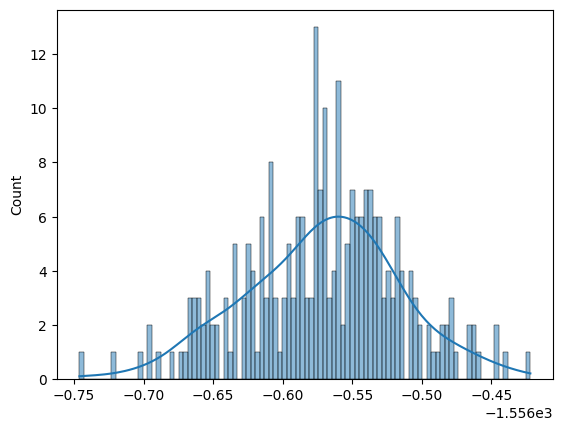

In [88]:
sns.histplot(y_pertrubed, kde=True, bins=100)

In [89]:
const_lowest_energy_original = np.full(simulation_count, lowest_energy_pred)
const_lowest_energy_predicted = np.full(simulation_count, energy_levels[idx_lowest])

print("--- SIMULATED")
print(f"Mean: {np.mean(y_pertrubed):.4f}")
print(f"Var : {np.var(y_pertrubed):.4f}")
print(f"Skew: {sp.stats.skew(y_pertrubed):.4f}")
print(f"Predicted energy: {lowest_energy_pred:.4f}")
print(f"Actual energy   : {energy_levels[idx_lowest]:.4f}")

print("--- Compared to Original Structure Energy")
print(f"MAE : {mean_absolute_error(const_lowest_energy_original, y_pertrubed):.4f}")
print(f"RMSE: {root_mean_squared_error(const_lowest_energy_original, y_pertrubed):.4f}")

print("--- Compared to Predicted Energy")
print(f"MAE : {mean_absolute_error(const_lowest_energy_predicted, y_pertrubed):.4f}")
print(f"RMSE: {root_mean_squared_error(const_lowest_energy_predicted, y_pertrubed):.4f}")

--- SIMULATED
Mean: -1556.5714
Var : 0.0031
Skew: -0.1694
Predicted energy: -1556.5751
Actual energy   : -1557.2095
--- Compared to Original Structure Energy
MAE : 0.0438
RMSE: 0.0555
--- Compared to Predicted Energy
MAE : 0.6380
RMSE: 0.6404


In [90]:
ttest_result = sp.stats.ttest_1samp(y_pertrubed, energy_levels[idx_lowest])
ttest_ci = ttest_result.confidence_interval(confidence_level=0.95)

print("--- Compared to Original Structure Energy")
print(f"t stat: {ttest_result.statistic:.4f}")
print(f"p-value: {ttest_result.pvalue:.4f}")
print(f"df: {ttest_result.df:,}")
print(f"lower ci: {ttest_ci.low:.4f}")
print(f"upper ci: {ttest_ci.high:.4f}")

--- Compared to Original Structure Energy
t stat: 181.8720
p-value: 0.0000
df: 249
lower ci: -1556.5783
upper ci: -1556.5645


In [91]:
ttest_result = sp.stats.ttest_1samp(y_pertrubed, lowest_energy_pred)
ttest_ci = ttest_result.confidence_interval(confidence_level=0.95)

print("--- Compared to Predicted Energy")
print(f"t stat: {ttest_result.statistic:.4f}")
print(f"p-value: {ttest_result.pvalue:.4f}")
print(f"df: {ttest_result.df:,}")
print(f"lower ci: {ttest_ci.low:.4f}")
print(f"upper ci: {ttest_ci.high:.4f}")

--- Compared to Predicted Energy
t stat: 1.0412
p-value: 0.2988
df: 249
lower ci: -1556.5783
upper ci: -1556.5645
